# Processing of the flux matrices
[Index](0-index.ipynb)

Flux matrices were computed using the SafeGraph [Social Distancing Metrics](https://docs.safegraph.com/docs/social-distancing-metrics) dataset and pooling the fluxes in $N=2^{10}$ communities as computed in [1-clustering](1-clustering.ipynb). The script used is shown [here](../code/compute_flux_matrices.py), although we do not provide the SafeGraph dataset here.

## Imports and global variables

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime
import scipy.stats as scs

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import matplotlib.colors as mco
import matplotlib.gridspec as mgs
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib import animation
plt.rcParams['svg.fonttype'] = 'none'

from IPython.display import HTML
from IPython.display import Image

In [3]:
sys.path.append('../code')
from functions import show_image

In [4]:
resdir = Path('../results/')
if not resdir.is_dir():
    raise ValueError('No results directory!')

In [5]:
resfile = resdir / 'safegraph_analysis.hdf5'
complevel=7
complib='zlib'
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    print(f"File {resfile.stem} has {len(store.keys())} entries.")

File safegraph_analysis has 830 entries.


In [6]:
tfmt = '%Y-%m-%d'

In [7]:
figdir = Path('../figures') / '2-fluxes'
if not figdir.is_dir():
    figdir.mkdir(parents=True, exist_ok=True)

dpi=300
exts = ['.png', '.svg']

## Clusters

### Load clusters

In [8]:
key = "/clustering/clusters"
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    clusters = store[key]
# clusters = pd.read_hdf(resfile, key)
N = len(clusters)
print(f"N = {N}")
clusters

N = 1024


,leaves,X,Y,cbg_clusters,population,mobile_count
index,,,,,,
0,746,-65.794825,18.277415,"[720531504003, 720531501044, 720531505001, 720...",390728,8705.198547
1,458,-66.083320,18.131576,"[720572702011, 720572703004, 720572705001, 720...",488287,10942.351090
2,873,-66.079340,18.396328,"[720210307001, 720210310113, 720210316223, 720...",1011530,28389.915254
3,8,-66.344566,18.363775,"[720399559001, 720399556001, 720399557001, 720...",425126,9988.154964
4,641,-66.582628,18.044742,"[721130724005, 721130727011, 721130727012, 721...",354598,12057.116223
...,...,...,...,...,...,...
1019,911,-158.026269,21.423245,"[150030078092, 150030078102, 150030099044, 150...",459209,22780.496368
1020,7,-157.813184,21.329035,"[150090318011, 150099900000, 150030047001, 150...",529047,21868.060533
1021,392,-156.517054,20.867763,"[150090311032, 150090304042, 150090309034, 150...",161290,7878.004843


In [9]:
key = "/clustering/cbgs_clusters"
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    cbgs_labels = store[key]

df = clusters.copy().loc[:,'leaves'].reset_index().set_index('leaves')
cbgs_labels['index'] = -1

for cbgs in cbgs_labels.index:
    cbgs_labels.at[cbgs, 'index'] = df.at[cbgs_labels.at[cbgs, 'leaves'],'index']

cbgs_labels

,leaves,index
CensusBlockGroup,,
10810416001,68,200
10810416002,68,200
10810417004,68,200
10730111074,440,195
10730111084,440,195
...,...,...
720851902012,746,0
720851902013,746,0
720851902021,746,0


### Represent on a map

In [10]:
XY = clusters.loc[:, ['X', 'Y']].to_numpy()
indices = clusters.index.to_numpy()
X,Y = XY.T

In [11]:
norm = mco.Normalize(vmin=np.min(indices), vmax=np.max(indices))
cmap = cm.rainbow

colors = cmap(norm(indices))

In [12]:
fig = plt.figure(figsize=(4,3),dpi=300)
ax = fig.gca()
for i in range(len(X)):
    x = X[i]
    y = Y[i]
    circle = plt.Circle((x,y), 0.5, color=colors[i], alpha=0.5, lw=0)
    ax.add_patch(circle)
    
xmin = np.min(X)
xmax = np.max(X)
ymin = np.min(Y)
ymax = np.max(Y)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect('equal')
for lab in 'left', 'right', 'bottom', 'top':
    ax.spines[lab].set_visible(False)
ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
cax = fig.add_axes(rect=[0.98,0.1,0.02,0.7])
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, label='Matrix index', extendfrac='auto')

fname = 'map_communities'
for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
# plt.show()
fig.clf()
plt.close('all')

Written file: ../figures/2-fluxes/map_communities.png
Written file: ../figures/2-fluxes/map_communities.svg


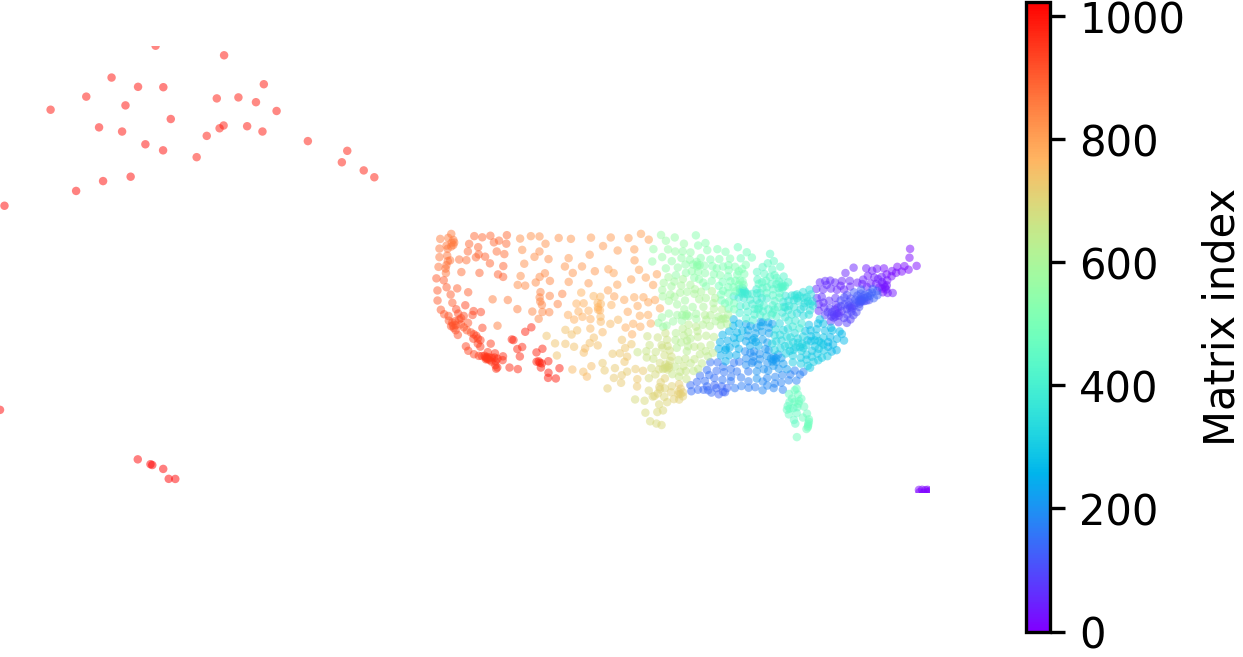

In [13]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

## Process flux matrices

### List the entries

In [14]:
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    for rt, grps, keys in store.walk('/fluxes'):
        pass
prefs = [k for k in keys]
print("len(prefs) = {:d}".format(len(prefs)))
# prefs

len(prefs) = 413


### Compute and show mean matrix

In [15]:
N = len(clusters)
fmat_mean = np.zeros((N,N), dtype=np.float_)
fmat_var = np.zeros((N,N), dtype=np.float_)

count = 0
for i, pref in enumerate(prefs):
    # define all store keys
    key_f = "/fluxes/{:s}".format(pref)    
#     print(f"File {i+1} / {len(prefs)}", key_f)
    
    with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:            
        F = store[key_f].to_numpy()
        
    # average
    fmat_mean += F
    fmat_var += F**2
    count += 1

fmat_mean = fmat_mean / count
fmat_var = fmat_var / count - fmat_mean**2

In [16]:
fname = 'fluxes_mean'
for ext in exts:
    filepath = figdir / (fname + ext)
    fig = show_image(fmat_mean, fileout=filepath, downscale=None, log=True, mpl=True)

Written file ../figures/2-fluxes/fluxes_mean.png
Written file ../figures/2-fluxes/fluxes_mean.svg


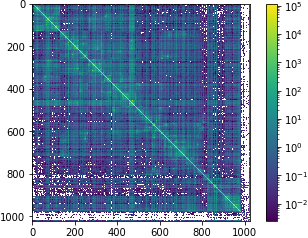

In [17]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

Check that $\sum_\limits{b} f_{ba} / M_a$ is small.

In [18]:
Ms = fmat_mean.diagonal()
idx = Ms > 0.
Minvs = np.zeros(Ms.shape)
Minvs[idx] = 1./Ms[idx]
A = fmat_mean.copy()
np.fill_diagonal(A, 0.)
A = np.einsum('ji,i->i', A, Minvs)
err = np.sum(A[idx]**2 / len(A))
print("std = {:.6e}".format(err))

std = 1.869965e-01


In [19]:
A = fmat_mean.T / np.diag(fmat_mean) - np.eye(N)
A[~np.isfinite(A)] = 0.
idx = A > 0.
M = np.sum(idx)
np.sqrt(np.sum(A[idx]**2/M))

<ipython-input-1-3dff990af063>:1: RuntimeWarning: invalid value encountered in true_divide
  A = fmat_mean.T / np.diag(fmat_mean) - np.eye(N)


0.005244559118064253

$\| F - F^T\| / \|F\|$ is small so the mean flux matrix is almost symmetric.

In [20]:
f = np.linalg.norm(fmat_mean)
err = np.linalg.norm(fmat_mean - fmat_mean.T)
err_rel = err/f
print("||F|| = {:.6e}".format(f), "||F - F^T|| = {:.6e}".format(err), "||F - F^T||/||F|| = {:.6e}".format(err_rel))

||F|| = 8.810861e+05 ||F - F^T|| = 6.292960e+04 ||F - F^T||/||F|| = 7.142275e-02


We can also represent the variance of the mean fluxes.

In [21]:
fname = 'fluxes_var'
for ext in exts:
    filepath = figdir / (fname + ext)
    fig = show_image(fmat_var, fileout=filepath, downscale=None, log=True, mpl=True)

Written file ../figures/2-fluxes/fluxes_var.png
Written file ../figures/2-fluxes/fluxes_var.svg


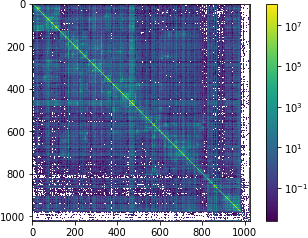

In [22]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

Export mean flux matrix

In [23]:
expdir = resdir / 'csv'
if not expdir.is_dir():
    expdir.mkdir()

In [24]:
fname = 'fluxes_mean.csv'
pd.DataFrame(data=fmat_mean, index=clusters.index.to_numpy(), columns=clusters.index.to_numpy()).to_csv(expdir / fname)

### What is the noise distribution?

In [25]:
mats = []
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    for pref in prefs:
        key_f = "/fluxes/{:s}".format(pref)
        mat = store[key_f].to_numpy()
        mats.append(mat)
mats = np.array(mats, dtype=np.float_)
mats.shape

mat_mean = np.mean(mats, axis=0)
mat_std = np.std(mats, axis=0)

#### Multiplicative noise

In [26]:
# only consider non-zero elements to compute the distribution
# of non-zero elements of m_ij / <m_ij>
idx = mat_mean > 0.
data = []
for i in range(len(prefs)):
    idxi = mats[i] > 0.
    idxi = idx & idxi
    data.append(mats[i][idxi] / mat_mean[idxi])
data = np.concatenate(data)
data = np.sort(data)

In [27]:
# nbins=2**6
nbins='doane'
q = 0.00
n = len(data)
n1 = int(0.5*q*n)
n2 = int((1. - 0.5*q)*n)
print(f"n1 = {n1}, n2 = {n2}")

fig = plt.figure(figsize=(4,3), dpi=150)
ax = fig.gca()

# hist, edges = np.histogram(data[n1:n2], bins=nbins, density=True)
hist, edges = np.histogram(np.log(data[n1:n2]), bins=nbins, density=True)

print(f"nbins = ", len(edges)-1)
ax.plot(0.5*(edges[:-1]+edges[1:]), hist, '-o', lw=0.5, color='darkblue', ms=2)

m = np.mean(np.log(data[n1:n2]))
s = np.std(np.log(data[n1:n2]))
m,s = scs.norm.fit(np.log(data[n1:n2]), loc=m, scale=s)
npts = 1000
X = np.linspace(edges[0], edges[-1], npts)
Y = 1./ np.sqrt(2.*np.pi*s**2)*np.exp(-0.5*(X-m)**2/s**2)
ax.plot(X,Y,'r--',lw=0.5, label="$\\mu = {:.2f}$\n$\sigma = {:.2f}$".format(m, s))

ax.legend(loc='best', fontsize='medium', frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("$\ln{(m_{ij}/\\mu_{ij})}$", fontsize='large')
ax.set_ylabel("pdf", fontsize='medium')
fig.tight_layout()

fname = 'noise_distribution_multiplicative'
for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

n1 = 0, n2 = 121104407
nbins =  40
Written file: ../figures/2-fluxes/noise_distribution_multiplicative.png
Written file: ../figures/2-fluxes/noise_distribution_multiplicative.svg


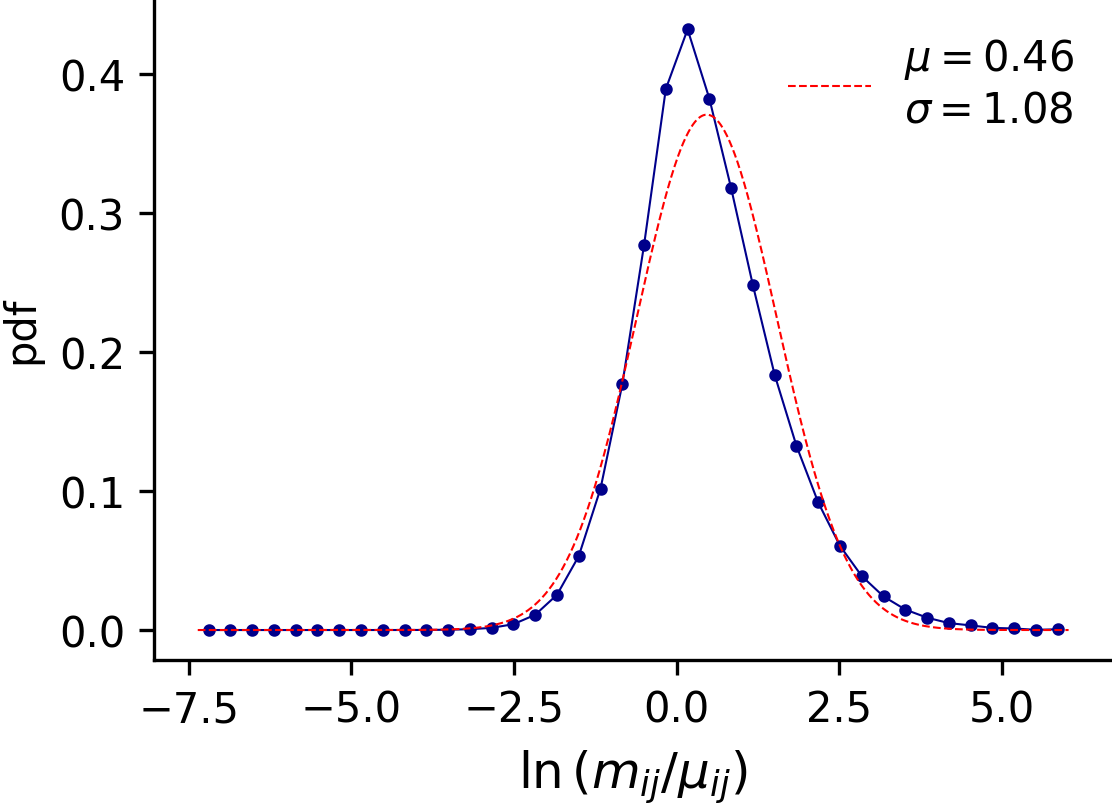

In [28]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

#### Additive noise

In [29]:
# only consider non-zero elements to compute the distribution
# of non-zero elements of (m_ij - <m_ij>)/ s_ij
idx = mat_std > 0.
data = []
for i in range(len(prefs)):
    idxi = mats[i] > 0.
    idxi = idx & idxi
    data.append( (mats[i][idxi] - mat_mean[idxi])/mat_std[idxi])
data = np.concatenate(data)
data = np.sort(data)

In [30]:
# nbins=2**6
nbins='doane'
q = 0.00
n = len(data)
n1 = int(0.5*q*n)
n2 = int((1. - 0.5*q)*n)
print(f"n1 = {n1}, n2 = {n2}")

fig = plt.figure(figsize=(4,3), dpi=150)
ax = fig.gca()

hist, edges = np.histogram(data[n1:n2], bins=nbins, density=True)
# hist, edges = np.histogram(np.log(data[n1:n2]), bins=nbins, density=True)

print(f"nbins = ", len(edges)-1)
ax.plot(0.5*(edges[:-1]+edges[1:]), hist, '-o', lw=0.5, color='darkblue', ms=2)

# m = np.mean(np.log(data[n1:n2]))
# s = np.std(np.log(data[n1:n2]))
# m,s = scs.norm.fit(np.log(data[n1:n2]), loc=m, scale=s)
# npts = 1000
# X = np.linspace(edges[0], edges[-1], npts)
# Y = 1./ np.sqrt(2.*np.pi*s**2)*np.exp(-0.5*(X-m)**2/s**2)
# ax.plot(X,Y,'r--',lw=0.5, label="$\\mu = {:.2f}$\n$\sigma = {:.2f}$".format(m, s))

ax.legend(loc='best', fontsize='medium', frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("$(m_{ij} - \\mu_{ij})/\sigma_{ij}$", fontsize='large')
ax.set_ylabel("pdf", fontsize='medium')
fig.tight_layout()

fname = 'noise_distribution_additive'
for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')
# plt.show()

n1 = 0, n2 = 121104407


No handles with labels found to put in legend.


nbins =  42
Written file: ../figures/2-fluxes/noise_distribution_additive.png
Written file: ../figures/2-fluxes/noise_distribution_additive.svg


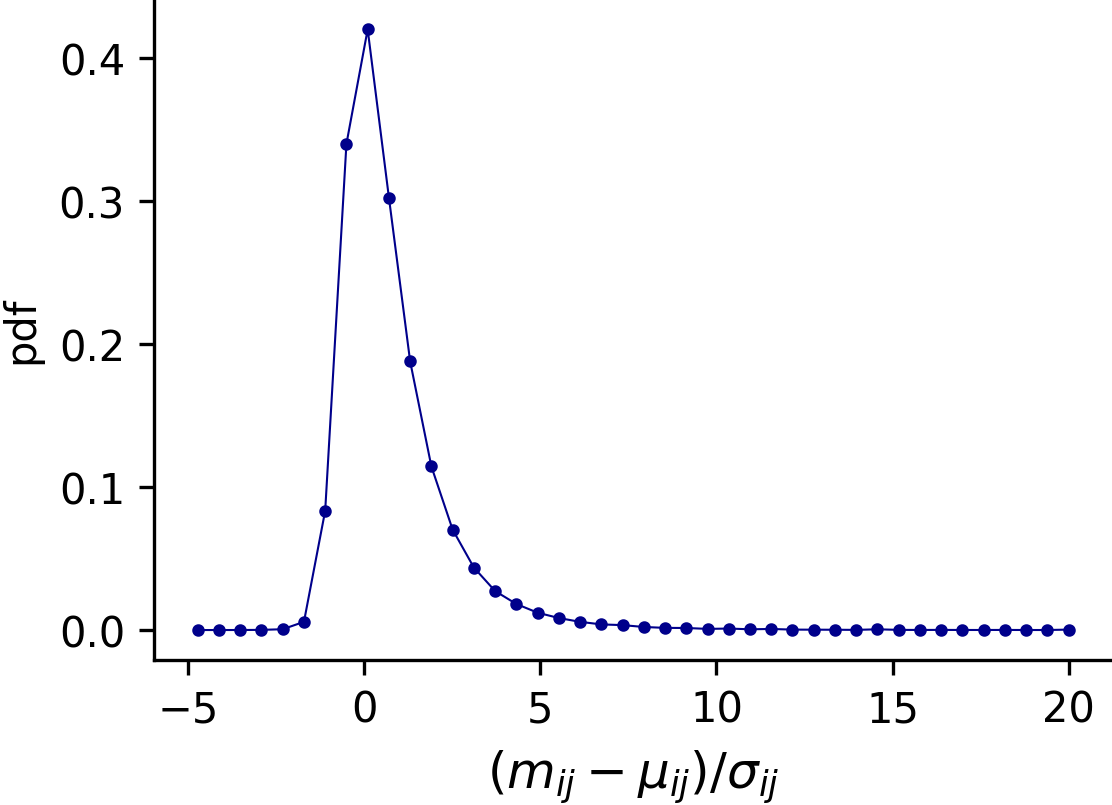

In [31]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

## Compute and show the total fluxes

In [32]:
ts = []
data = []
count = 0
idump = 10
for i, pref in enumerate(prefs):
    # define all store keys
    key_f = "/fluxes/{:s}".format(pref)
    
    if (i%idump == 0):
        print(f"File {i+1} / {len(prefs)}", key_f)
    
    t = datetime.datetime.strptime(pref, tfmt)
    
    with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
        if not (key_f in store):
            print(f"skipping!")
            continue
    
        fmat = store[key_f].to_numpy().astype('float64')
        
    ts.append(t)
    fsum = np.sum(fmat)
    ftrace = np.einsum('ii', fmat)
    data.append([fsum - ftrace, ftrace, float(fsum - ftrace)/ftrace])

ts = np.array(ts)
data = np.array(data)

df_flux_tot = pd.DataFrame(data=data, columns=['flux', 'mobile count', 'relative flux'], index=ts)

File 1 / 413 /fluxes/2020-01-01
File 11 / 413 /fluxes/2020-01-11
File 21 / 413 /fluxes/2020-01-21
File 31 / 413 /fluxes/2020-01-31
File 41 / 413 /fluxes/2020-02-10
File 51 / 413 /fluxes/2020-02-20
File 61 / 413 /fluxes/2020-03-01
File 71 / 413 /fluxes/2020-03-11
File 81 / 413 /fluxes/2020-03-21
File 91 / 413 /fluxes/2020-03-31
File 101 / 413 /fluxes/2020-04-10
File 111 / 413 /fluxes/2020-04-20
File 121 / 413 /fluxes/2020-04-30
File 131 / 413 /fluxes/2020-05-10
File 141 / 413 /fluxes/2020-05-20
File 151 / 413 /fluxes/2020-05-30
File 161 / 413 /fluxes/2020-06-09
File 171 / 413 /fluxes/2020-06-19
File 181 / 413 /fluxes/2020-06-29
File 191 / 413 /fluxes/2020-07-09
File 201 / 413 /fluxes/2020-07-19
File 211 / 413 /fluxes/2020-07-29
File 221 / 413 /fluxes/2020-08-08
File 231 / 413 /fluxes/2020-08-18
File 241 / 413 /fluxes/2020-08-28
File 251 / 413 /fluxes/2020-09-07
File 261 / 413 /fluxes/2020-09-17
File 271 / 413 /fluxes/2020-09-27
File 281 / 413 /fluxes/2020-10-07
File 291 / 413 /fluxes/20

In [33]:
fig = plt.figure(figsize=(4,3), dpi=150)
ax = fig.gca()

ax.plot(df_flux_tot.index, df_flux_tot['flux'].to_numpy()/1e6, 'o', ms=2)

plt.xticks(rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel("total flux (M)", fontsize='medium')
fig.tight_layout()

fname = 'total_fluxes'
for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

Written file: ../figures/2-fluxes/total_fluxes.png
Written file: ../figures/2-fluxes/total_fluxes.svg


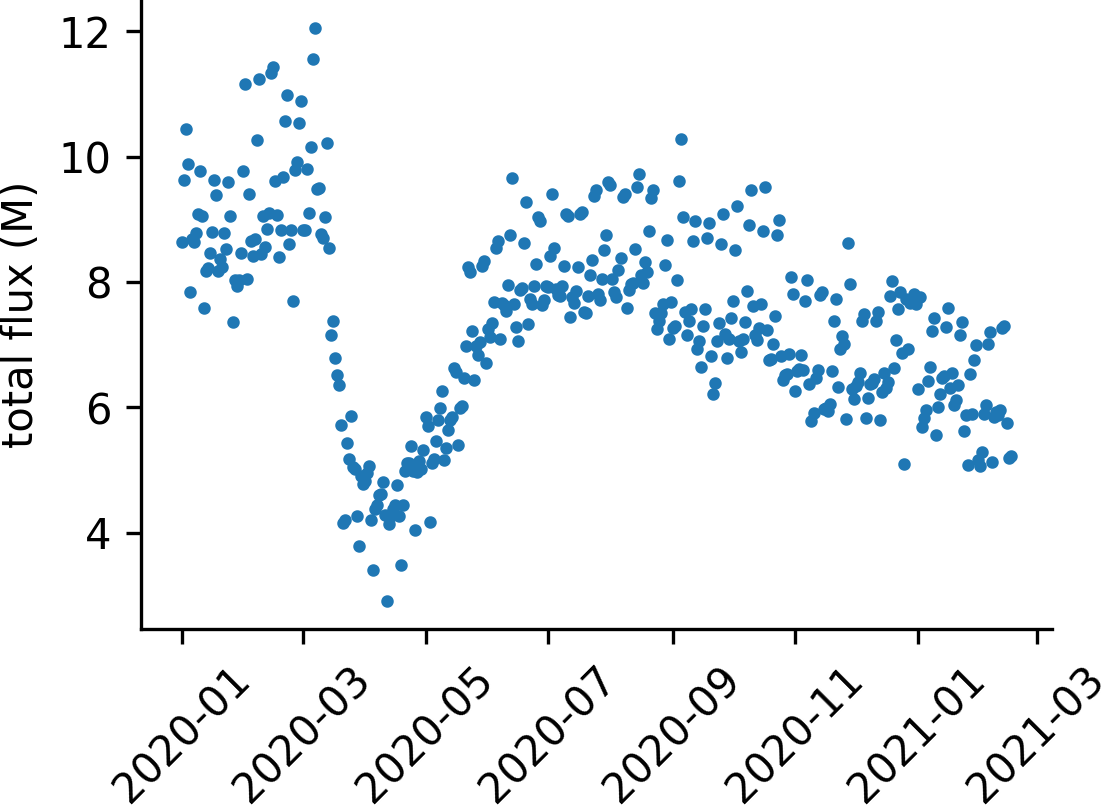

In [34]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

### Analyze the mobile phone count

In [35]:
idump =10
ts = []
data = []
count = 0
for i, pref in enumerate(prefs):
    # define all store keys
    key_f = "/fluxes/{:s}".format(pref)
    
    if i % idump == 0:
        print(f"File {i+1} / {len(prefs)}", key_f)
    
    t = datetime.datetime.strptime(pref, tfmt)
    
    with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
        if not (key_f in store):
            print(f"skipping!")
            continue
    
        fmat = store[key_f].to_numpy().astype('float64')
            
    pvec = np.einsum('ii->i', fmat)
    
    ts.append(t)
    data.append(pvec)
    
df_pvec = pd.DataFrame(data=data, columns=clusters.index, index=ts)

File 1 / 413 /fluxes/2020-01-01
File 11 / 413 /fluxes/2020-01-11
File 21 / 413 /fluxes/2020-01-21
File 31 / 413 /fluxes/2020-01-31
File 41 / 413 /fluxes/2020-02-10
File 51 / 413 /fluxes/2020-02-20
File 61 / 413 /fluxes/2020-03-01
File 71 / 413 /fluxes/2020-03-11
File 81 / 413 /fluxes/2020-03-21
File 91 / 413 /fluxes/2020-03-31
File 101 / 413 /fluxes/2020-04-10
File 111 / 413 /fluxes/2020-04-20
File 121 / 413 /fluxes/2020-04-30
File 131 / 413 /fluxes/2020-05-10
File 141 / 413 /fluxes/2020-05-20
File 151 / 413 /fluxes/2020-05-30
File 161 / 413 /fluxes/2020-06-09
File 171 / 413 /fluxes/2020-06-19
File 181 / 413 /fluxes/2020-06-29
File 191 / 413 /fluxes/2020-07-09
File 201 / 413 /fluxes/2020-07-19
File 211 / 413 /fluxes/2020-07-29
File 221 / 413 /fluxes/2020-08-08
File 231 / 413 /fluxes/2020-08-18
File 241 / 413 /fluxes/2020-08-28
File 251 / 413 /fluxes/2020-09-07
File 261 / 413 /fluxes/2020-09-17
File 271 / 413 /fluxes/2020-09-27
File 281 / 413 /fluxes/2020-10-07
File 291 / 413 /fluxes/20

Show the cell phone count per community is approximately constant

In [36]:
indices = np.arange(len(df_pvec.index))
norm = mco.Normalize(vmin=np.min(indices), vmax=np.max(indices))
cmap = cm.rainbow
colors = cmap(norm(indices))

fig = plt.figure(figsize=(10,2), dpi=300)
ax=fig.gca()


for i in range(len(indices)):
    ax.plot(df_pvec.loc[df_pvec.index[i]], '-', color=colors[i], lw=0.5, ms=0, alpha=0.1)

ax.plot(np.diag(fmat_mean), 'k--', lw=0.5)

for lab in 'right', 'top':
    ax.spines[lab].set_visible(False)
ax.tick_params(length=4)
ax.set_xlim(0.,None)
ax.set_ylim(1,None)
ax.set_xlabel('cluster index', fontsize='medium')
ax.set_ylabel('# devices', fontsize='medium')
ax.set_yscale('log')
cax = fig.add_axes(rect=[0.99,0.1,0.01,0.7])
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, extendfrac='auto')
ticks = cbar.get_ticks()
labels = df_pvec.index[ticks.astype('int64')].strftime('%Y-%m-%d').tolist()
cbar.set_ticks(ticks)
cbar.set_ticklabels(labels)

fname = 'devices_per_community'
for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

# plt.show()


Written file: ../figures/2-fluxes/devices_per_community.png
Written file: ../figures/2-fluxes/devices_per_community.svg


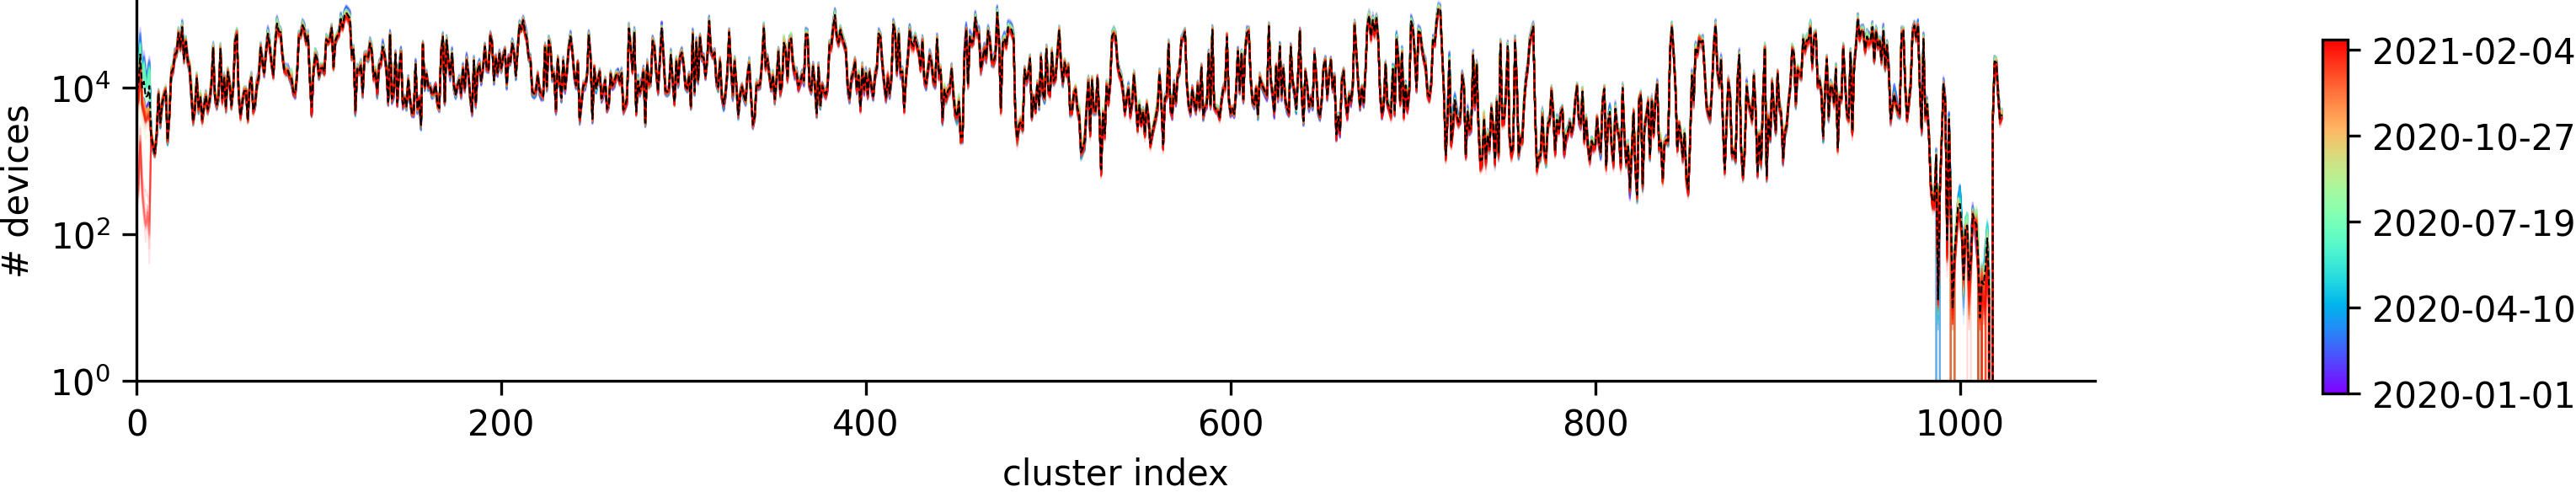

In [37]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, height=360)

Show that the cell phone count is a good proxy for actual population, by comparing the cell phone count with the Census Bureau reported population.

In [38]:
s_pvec_mean = df_pvec.mean(axis=0)

clusters['mobile_count'] = s_pvec_mean
key = "/clustering/clusters"
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    store[key] = clusters
clusters

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3441: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['cbg_clusters'], dtype='object')]

  exec(code_obj, self.user_global_ns, self.user_ns)


,leaves,X,Y,cbg_clusters,population,mobile_count
index,,,,,,
0,746,-65.794825,18.277415,"[720531504003, 720531501044, 720531505001, 720...",390728,8705.198547
1,458,-66.083320,18.131576,"[720572702011, 720572703004, 720572705001, 720...",488287,10942.351090
2,873,-66.079340,18.396328,"[720210307001, 720210310113, 720210316223, 720...",1011530,28389.915254
3,8,-66.344566,18.363775,"[720399559001, 720399556001, 720399557001, 720...",425126,9988.154964
4,641,-66.582628,18.044742,"[721130724005, 721130727011, 721130727012, 721...",354598,12057.116223
...,...,...,...,...,...,...
1019,911,-158.026269,21.423245,"[150030078092, 150030078102, 150030099044, 150...",459209,22780.496368
1020,7,-157.813184,21.329035,"[150090318011, 150099900000, 150030047001, 150...",529047,21868.060533
1021,392,-156.517054,20.867763,"[150090311032, 150090304042, 150090309034, 150...",161290,7878.004843


In [39]:
clusters.loc[(clusters['population'] == 0) | (clusters['mobile_count'] == 0)]

,leaves,X,Y,cbg_clusters,population,mobile_count
index,,,,,,
1017,236,-175.828603,27.854941,[150039812001],0,0.0


In [40]:
df_pvecT = df_pvec.T

indices = np.arange(len(df_pvec.index))
norm = mco.Normalize(vmin=np.min(indices), vmax=np.max(indices))
cmap = cm.rainbow
colors = cmap(norm(indices))

ncol = 2
fig = plt.figure(facecolor='w', figsize=(8,3), dpi=300)
gs = mgs.GridSpec(1, ncol)

idx = clusters.index
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

X1 = clusters.loc[idx, 'population'].to_numpy()
xsum = np.sum(X1)
X2 = X1 / xsum
matX1 = []
matX2 = []
matY1 = []
matY2 = []
for i in range(len(indices)):
    t = df_pvecT.columns[i]
    Y1 = df_pvecT.loc[idx,t].to_numpy()
    
    ax1.plot(X1, Y1, 'o', color=colors[i], lw=0, ms=2, alpha=0.1)
    matX1.append(X1)
    matY1.append(Y1)
    
    ysum = np.sum(Y1)
    Y2 = Y1 / ysum
    ax2.plot(X2, Y2, 'o', color=colors[i], lw=0, ms=2, alpha=0.1)
    matX2.append(X2)
    matY2.append(Y2)

# fits
matX1 = np.ravel(matX1)
matY1 = np.ravel(matY1)
matX2 = np.ravel(matX2)
matY2 = np.ravel(matY2)

# res = scs.linregress(matX1, matY1)
# a1 = res.slope
# b1 = res.intercept
b1 = 0.
a1 = np.sum(matY1) / np.sum(matX1)
Xfit = np.array([0., np.max(X1)])
ax1.plot(Xfit, a1*Xfit +b1, 'k-', lw=1.)

# res = scs.linregress(matX2, matY2)
# a2 = res.slope
# b2 = res.intercept
b2 = 0.
a2 = np.sum(matY2) / np.sum(matX2)
Xfit = np.array([0., np.max(X2)])
ax2.plot(Xfit, a2*Xfit +b2, 'k-', lw=1.)

# plot formatting
ax1.set_xlabel("$M_a$", fontsize='medium')
ax1.set_ylabel("$P_a$", fontsize='medium')
ax2.set_xlabel("$M_a / \sum M_a$", fontsize='medium')
ax2.set_ylabel("$P_a / \sum P_a$", fontsize='medium')
for ax in ax1, ax2:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(bottom=True, left=True, labelbottom=True, labelleft=True)
    ax.tick_params(length=4)
    ax.set_xlim(0., None)
    ax.set_ylim(0., None)
# ax.set_xlim(0.5, 1.5)
# ax.set_ylim(0.5, 1.5)
# ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
# ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
# ax.set_aspect('equal')
        
# ax.legend(loc='upper left', fontsize='small', bbox_to_anchor=(1.1, 0.98), frameon=False, ncol=3)
    
gs.tight_layout(fig, rect=[0.,0.,0.95,1.])
cax = fig.add_axes(rect=[0.99,0.2,0.01,0.7])
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, extendfrac='auto')
ticks = cbar.get_ticks()
labels = df_pvec.index[ticks.astype('int64')].strftime('%Y-%m-%d').tolist()
cbar.set_ticks(ticks)
cbar.set_ticklabels(labels)

fname = 'devices_vs_population'
for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')
# plt.show()

Written file: ../figures/2-fluxes/devices_vs_population.png
Written file: ../figures/2-fluxes/devices_vs_population.svg


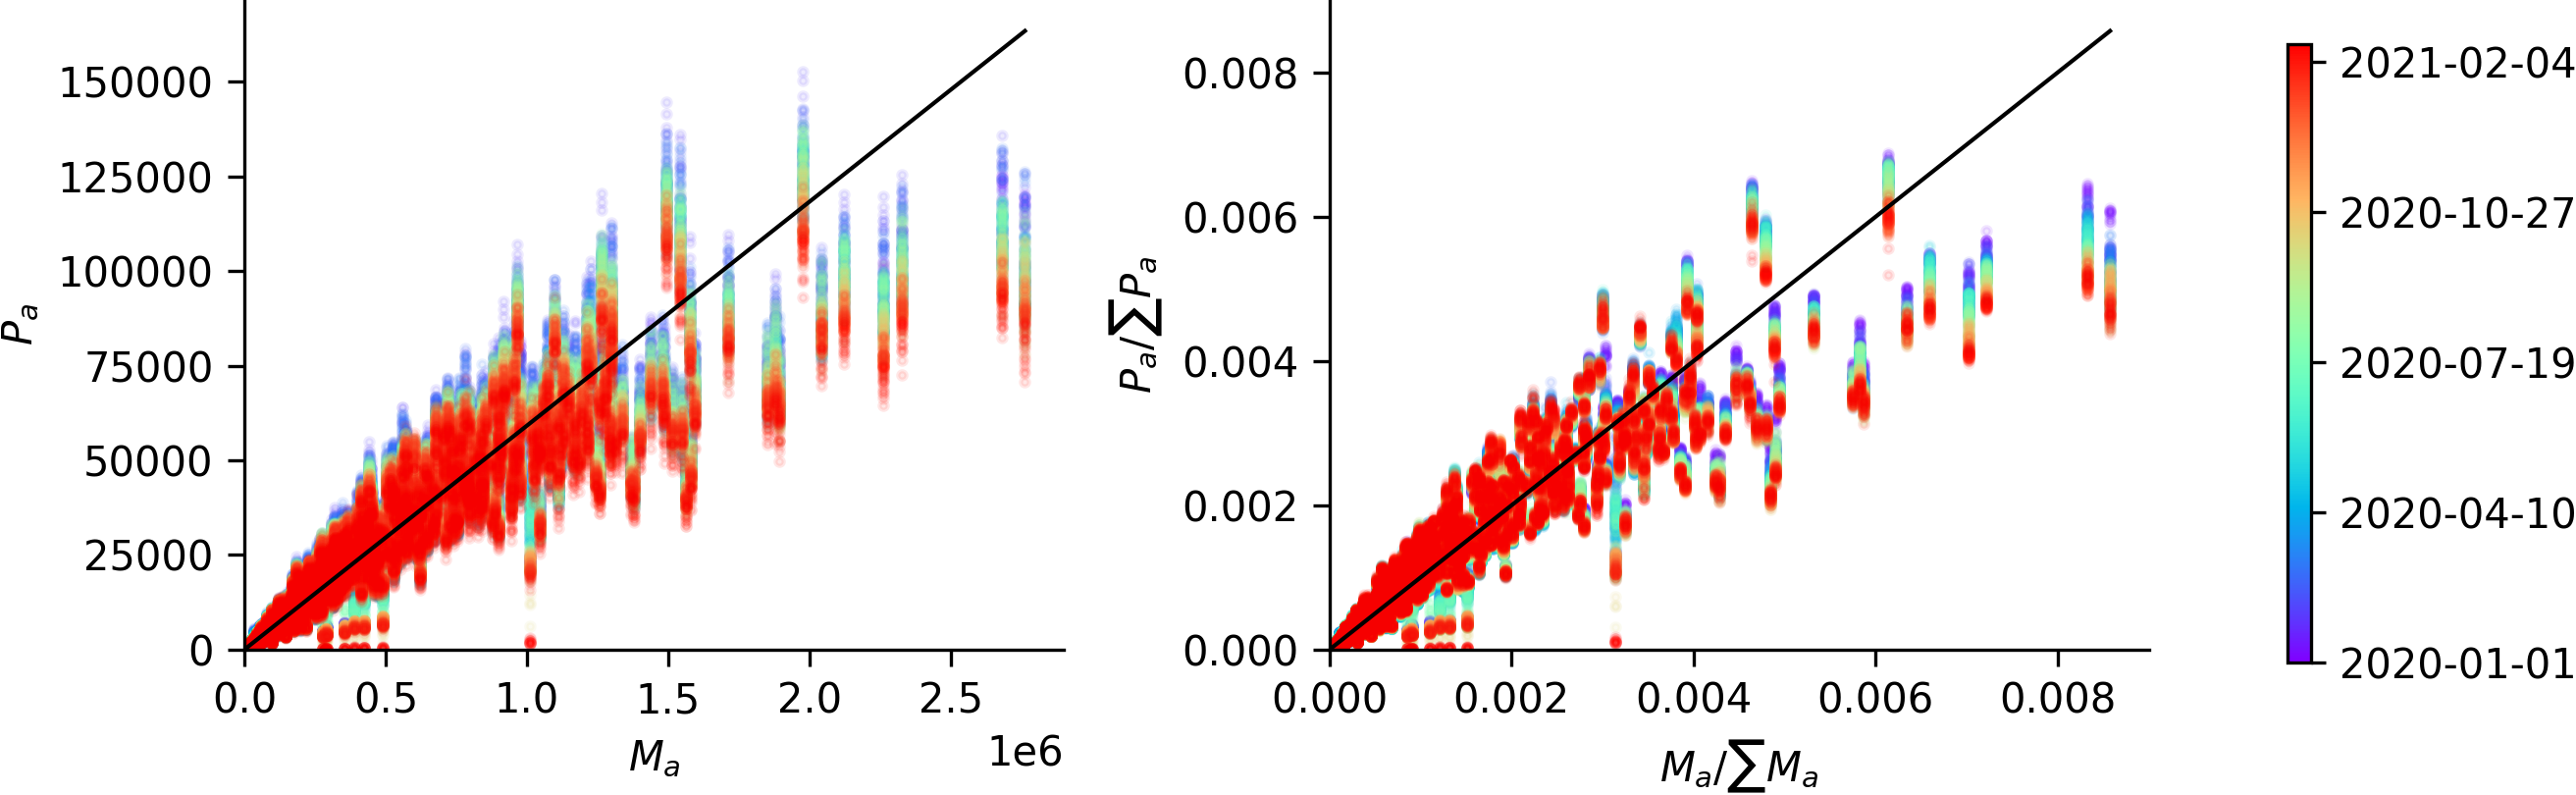

In [41]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, height=360)